In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from random import Random
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
import math

url1 = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_daily_symptoms_dataset.csv'
url2 = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv'
dataset1 = pd.read_csv(url1)
dataset2 = pd.read_csv(url2)
search_trends = pd.DataFrame(dataset1)
covid_cases = pd.DataFrame(dataset2)

pd.set_option('display.max_rows', covid_cases.shape[0]+1)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **Task 1: Acquire, process, and analyze the data**

### Cleanup of the first dataset

1. We drop all features that don't have enough data (more than 70%)
2. We convert from daily to weekly

In [2]:
# Let's create a processed search trends dataset
# 1
processed_search_trends = search_trends.dropna(axis = 1, thresh = 0.70 * len(search_trends.index))

# 2 convert to weekly
processed_search_trends['date'] = processed_search_trends['date'].astype('datetime64[ns]')
processed_search_trends = processed_search_trends.groupby('open_covid_region_code').resample(
    'W-MON',
    label='left',
    closed = 'left',
    on='date',
).sum().reset_index().sort_values(by='open_covid_region_code')
processed_search_trends['date'] = processed_search_trends['date'].astype('string')

# We also have to convert the search_trends to weekly but without the data cleaning above since we keep all features
search_trends = pd.concat([search_trends[['open_covid_region_code', 'date']], search_trends.groupby('open_covid_region_code').transform(lambda x: x.fillna(x.mean()))], axis=1)
search_trends['date'] = search_trends['date'].astype('datetime64[ns]')
search_trends = search_trends.groupby('open_covid_region_code').resample(
    'W-MON',
    label='left',
    closed = 'left',
    on='date',
).sum().reset_index().sort_values(by=['open_covid_region_code','date'])
search_trends['date'] = search_trends['date'].astype('string')

We replace all NaN values by zero

In [3]:
search_trends.fillna(0, inplace=True)
processed_search_trends.fillna(0, inplace=True)

We then normalize the data by de-medianing to allow comparisons between regions

In [4]:
symptom_names = search_trends.columns[4:]
processed_symptom_names = processed_search_trends.columns[2:]

# 1
def divide_by_median(group):
  all_entries = []
  for index, row in group.iterrows():
    all_entries = np.concatenate((all_entries, row.values))
  median = np.median(all_entries)
  group = group.divide(median)
  group.replace([np.inf, -np.inf], 0, inplace=True)
  return group

temp_search_trends = search_trends.groupby('open_covid_region_code')[symptom_names].apply(lambda group: divide_by_median(group))
search_trends = pd.concat([search_trends[['open_covid_region_code', 'date']], temp_search_trends], axis=1)

temp_processed_search_trends = processed_search_trends.groupby('open_covid_region_code')[processed_symptom_names].apply(lambda group: divide_by_median(group))
processed_search_trends = pd.concat([processed_search_trends[['open_covid_region_code', 'date']], temp_processed_search_trends], axis=1)

And we finally do feature scaling on the data by applying a standard scaler to each region group

In [5]:
def standardize(group):
  transformed = preprocessing.StandardScaler().fit_transform(group.values)
  return pd.DataFrame(transformed, columns=group.columns, index=group.index)

standard_search_data = search_trends.groupby('open_covid_region_code')[symptom_names].apply(lambda group: standardize(group))

temp_processed_search_trends = processed_search_trends.groupby('open_covid_region_code')[processed_symptom_names].apply(lambda group: standardize(group))
processed_search_trends = pd.concat([processed_search_trends[['open_covid_region_code', 'date']], temp_processed_search_trends], axis=1)

### Cleanup of the second dataset

1. We only keep data from the US regions we can find in first dataset
2. We only keep date, covid_region and hospitalized_new
3. Convert to weekly resolution

In [6]:
# 1
us_regions = np.unique(processed_search_trends['open_covid_region_code'].values)
index_to_delete = []
for index, row in covid_cases.iterrows():
    if row.open_covid_region_code not in us_regions:
      index_to_delete.append(index)
covid_cases = covid_cases.drop(index=index_to_delete)

# 2
covid_cases = covid_cases[['open_covid_region_code','date','hospitalized_new']]

# 3
covid_cases['date'] = covid_cases['date'].astype('datetime64[ns]')
covid_cases = covid_cases.groupby('open_covid_region_code').resample(
    'W-MON',
    label='left',
    closed = 'left',
    on='date',
).sum().reset_index().sort_values(by='open_covid_region_code')
covid_cases['date'] = covid_cases['date'].astype('string')

After observation, we drop the regions which do not have enough data in hospitalized_new cases, i.e., too many zeros.

In [7]:
regions_to_drop = ['US-WV', 'US-TX', 'US-PA', 'US-NV', 'US-NC', 'US-MO', 'US-MI', 
                  'US-LA', 'US-IL', 'US-IA', 'US-DE', 'US-DC', 'US-CA', 'US-AK', 'US-NY', 'US-VT']
covid_cases.drop(covid_cases[covid_cases.open_covid_region_code.isin(regions_to_drop)]
                 .index, inplace=True)

### Merging the data based on the dates + covid region code


In [8]:
merged_data = pd.merge(
    processed_search_trends,
    covid_cases, how='inner',
    left_on=['open_covid_region_code', 'date'],
    right_on=['open_covid_region_code', 'date'],
)

# **Task 2: Visualize and cluster the data**

### Visualization of the evolution of popularity of various symptoms across different regions over time

We want to visualize the search trends of various symptoms depending on the region.<br>
Here are the symptoms chosen based on popularity : <br>
[ Anxiety, Infection, Pain, Fever, Cough, Cold ]


Note that we use the unprocessed search_trends dataset for the whole visualization part

**!!Use Jupyter Collab version to have the dropdown option with the below graph!!**

Dropdown(index=6, options=('US-AK', 'US-AL', 'US-AR', 'US-AZ', 'US-CA', 'US-CO', 'US-CT', 'US-DC', 'US-DE', 'U…

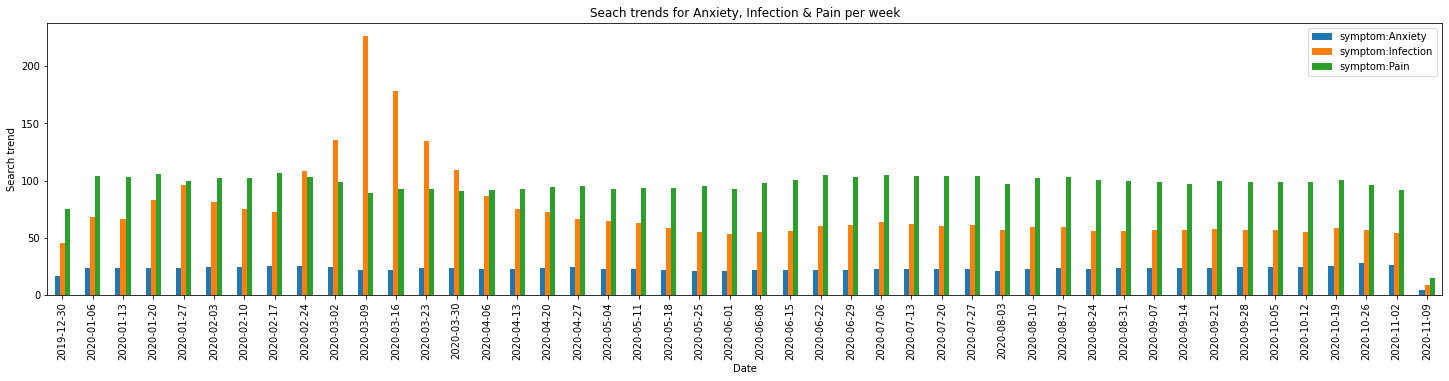

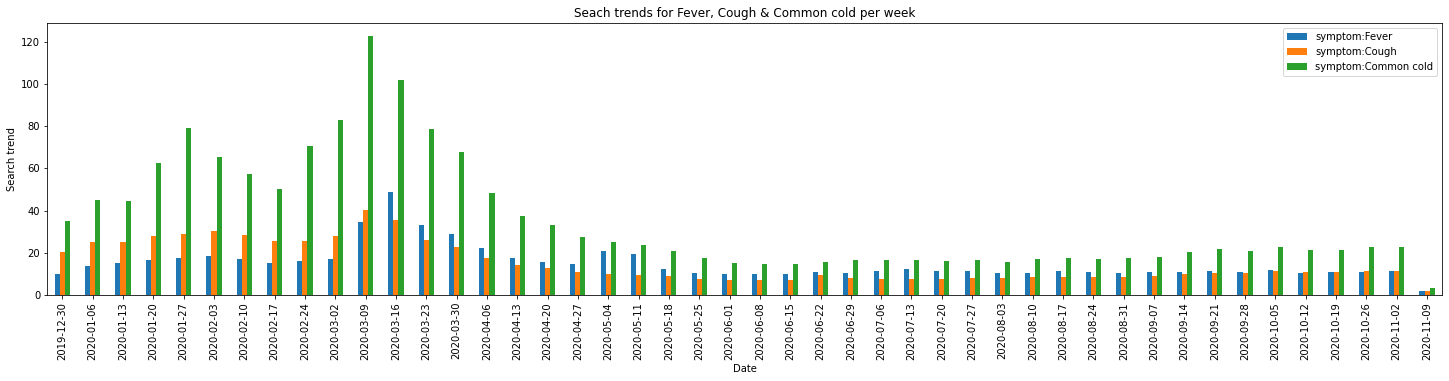

In [10]:
# Output the region codes dropdown
def output_dropdown(value):
  dropdown_region = widgets.Dropdown(options = us_regions_unprocessed, value = value)
  dropdown_region.observe(dropdown_eventhandler, names='value')
  display(dropdown_region) 

# Plot associated graphs when user selects new region code
# We use search_trends for the plotting as that is the dataset where we have not removed any rows/columns,
# and have not done standard scaling. 
# We want all the data, all we have done is replaced NaNs by zeros.
def dropdown_eventhandler(change):
  selected_code = change.new
  region_data = search_trends.loc[search_trends['open_covid_region_code'] == selected_code] 
  region_data.set_index('date', inplace=True)
  symptoms1 = region_data[['symptom:Anxiety','symptom:Infection','symptom:Pain']]
  symptoms2 = region_data[['symptom:Fever','symptom:Cough','symptom:Common cold']]
  symptoms1.plot.bar(figsize=(25,5))
  plt.title("Seach trends for Anxiety, Infection & Pain per week")
  plt.xlabel("Date")
  plt.ylabel("Search trend")
  symptoms2.plot.bar(figsize=(25,5))
  plt.title("Seach trends for Fever, Cough & Common cold per week")
  plt.xlabel("Date")
  plt.ylabel("Search trend")
  clear_output()
  output_dropdown(change.new)

us_regions_unprocessed = np.unique(search_trends['open_covid_region_code'].values)
output_dropdown(us_regions_unprocessed[0])


### Dimensionality Reduction

We loop through each possible number of dimensions $K$ 
reduced to by performing PCA. For each PCA model, we plot the loss and variance against $K$ to visualize which of these $K$ would be a good parameter so as to retain as most of the origin dataset's variance while reducing the number of dimensions as much as possible.

In [11]:
# loss function for the reconstruction error
def loss(original_data, reconstructed_data):
  return np.linalg.norm((original_data - reconstructed_data), None)

loss_vals = [] # array of loss values for all reduced dimensions
variance_vals = [] # array of variance values
dimension_vals = list(range(1, standard_search_data.shape[1]-1))

# loop over dimension values and see where the jumps in variance become negligible (variance_vals)
# spot dimensions of interest by plotting variance_vals and loss_vals
for k in dimension_vals:
  pca = PCA(n_components = k) # initialize pca model
  pca_data = pca.fit_transform(standard_search_data) # fit our data to the model with k dimensions
  principal_data = pd.DataFrame(data = pca_data) # store into pd dataframe
  variance_vals.append(sum(pca.explained_variance_ratio_)) # variance retained by our PCA model
  reconstructed_data = pca.inverse_transform(pca_data) # reconstruct data by inverse direction of the mapping
  loss_result = loss(standard_search_data, reconstructed_data) # calculate loss of our PCA model
  loss_vals.append(loss_result) 


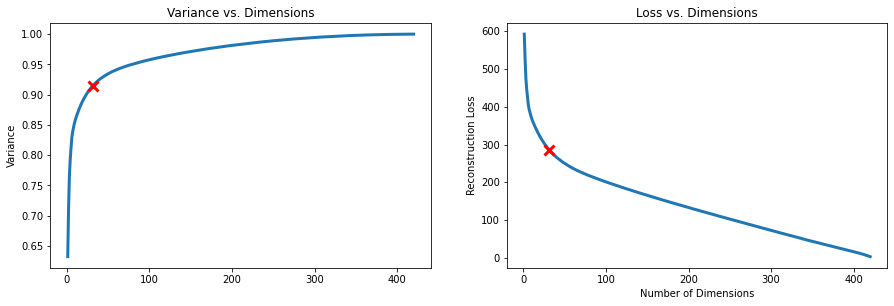

In [12]:
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(bottom=0.2)
ax1 = plt.subplot(121)
ax1.plot(dimension_vals, variance_vals, linewidth=3)
ax1.plot(dimension_vals[30], variance_vals[30], marker='x', color='r', mew=3, ms=10)
ax1.set_ylabel('Variance')
ax1.set_title('Variance vs. Dimensions')


ax2 = plt.subplot(122, sharex = ax1)
ax2.plot(dimension_vals, loss_vals, linewidth=3)
ax2.plot(dimension_vals[30], loss_vals[30], marker='x', color='r', mew=3, ms=10)
ax2.set_ylabel('Reconstruction Loss')
ax2.set_xlabel('Number of Dimensions')
ax2.set_title('Loss vs. Dimensions')
plt.show()

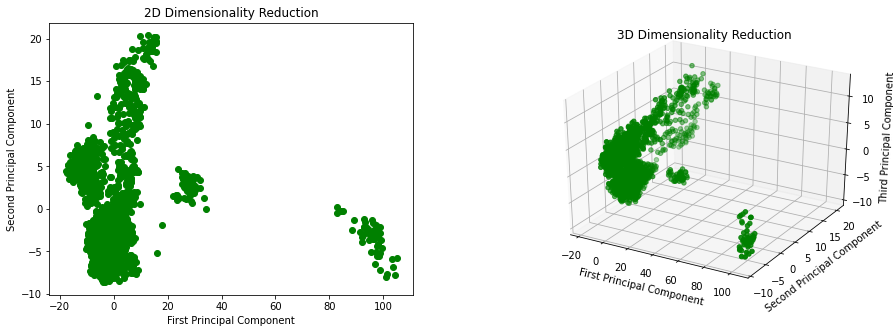

In [13]:
pca_2d = PCA(n_components=2)
pca_data2d = pca_2d.fit_transform(standard_search_data)
pca_data2d = pd.DataFrame(data= pca_data)

pca_3d = PCA(n_components=3)
pca_data3d = pca_3d.fit_transform(standard_search_data)
pca_data3d = pd.DataFrame(data=pca_data3d)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
plt.scatter(pca_data2d.values[:, 0], pca_data2d.values[:, 1], color='green')
plt.title('2D Dimensionality Reduction')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter3D(pca_data3d.values[:, 0], pca_data3d.values[:, 1], pca_data3d.values[:, 2], color='green')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.set_zlabel('Third Principal Component')
ax2.set_title('3D Dimensionality Reduction')

plt.subplots_adjust(wspace=0.3)

plt.show()

Calculate variance jumps looping through dimensions, spot where the jumps become very small

In [15]:
variance_jumps = [variance_vals[i] - variance_vals[i-1] for i in range(1, len(variance_vals))]
value = next(i for i in variance_jumps if i < 0.01)
K = variance_jumps.index(value) # in jumping from K to K + 1 dimensions, the added variance is very small

# another way of checking what dimensionality reduction is to check what number of PCs we need to retain a certain amount of variance
pca_95 = PCA(0.95)
pca_95_data = pca_95.fit_transform(standard_search_data)
pca_90 = PCA(0.90)
pca_90_data = pca_90.fit_transform(standard_search_data)
pca_99 = PCA(0.99)
pca_99_data = pca_99.fit_transform(standard_search_data)

pca_6d = PCA(n_components=6)
pca_6d_data = pca_6d.fit_transform(standard_search_data)
pca_15d = PCA(n_components=15)
pca_15d_data = pca_15d.fit_transform(standard_search_data)
pca_25d = PCA(n_components=25)
pca_25d_data = pca_25d.fit_transform(standard_search_data)

# Dimensions of interest for regression task
print(f'possible choices of K: {K, pca_15d.n_components_, pca_25d.n_components_, pca_90.n_components_, pca_95.n_components_, pca_99.n_components_}')

possible choices of K: (5, 15, 25, 24, 78, 257)


### Data Clustering

In [16]:
from sklearn import datasets
from sklearn.cluster import KMeans
raw_data = standard_search_data
pca_reduced_data = pca_95_data

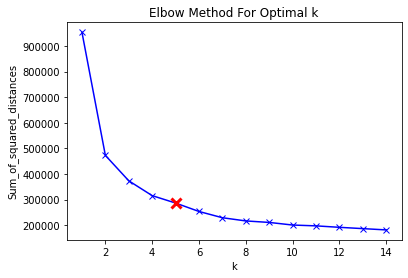

In [17]:
# snippet of code from https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(raw_data)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.plot(5, Sum_of_squared_distances[4], 'x', color='r', mew=3, ms=10)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

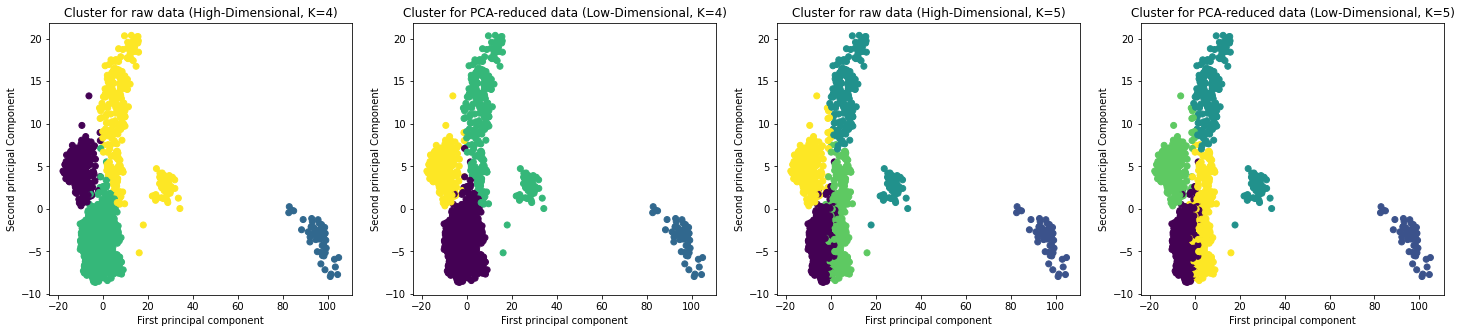

In [18]:
import matplotlib as mpl

Kmeans_fig = plt.figure(figsize=(25, 5))
ax1 = Kmeans_fig.add_subplot(1,4,1)
kmeans_raw = KMeans(n_clusters=4, random_state=0)
kmeans_raw.fit(raw_data)
y_pred_raw = kmeans_raw.predict(raw_data)
ax1.scatter(pca_reduced_data[:,0], pca_reduced_data[:,1], c=y_pred_raw, cmap=plt.get_cmap('viridis',4))
ax1.set_title('Cluster for raw data (High-Dimensional, K=4)')
ax1.set_xlabel('First principal component')
ax1.set_ylabel('Second principal Component')

ax2 = Kmeans_fig.add_subplot(1,4,2)
kmeans_pca_reduced = KMeans(n_clusters=4, random_state=0)
kmeans_pca_reduced.fit(pca_reduced_data)
y_pred_pca_reduced = kmeans_pca_reduced.predict(pca_reduced_data)
ax2.scatter(pca_reduced_data[:,0], pca_reduced_data[:,1], c=y_pred_pca_reduced, cmap=plt.get_cmap('viridis',4))
ax2.set_title('Cluster for PCA-reduced data (Low-Dimensional, K=4)')
ax2.set_xlabel('First principal component')
ax2.set_ylabel('Second principal Component')
plt.subplots_adjust(hspace=0.9)

ax3 = Kmeans_fig.add_subplot(1,4,3)
kmeans_raw = KMeans(n_clusters=5, random_state=0)
kmeans_raw.fit(raw_data)
y_pred_raw = kmeans_raw.predict(raw_data)
ax3.scatter(pca_reduced_data[:,0], pca_reduced_data[:,1], c=y_pred_raw, cmap=plt.get_cmap('viridis',5))
ax3.set_title('Cluster for raw data (High-Dimensional, K=5)')
ax3.set_xlabel('First principal component')
ax3.set_ylabel('Second principal Component')

ax4 = Kmeans_fig.add_subplot(1,4,4)
kmeans_pca_reduced = KMeans(n_clusters=5, random_state=0)
kmeans_pca_reduced.fit(pca_reduced_data)
y_pred_pca_reduced = kmeans_pca_reduced.predict(pca_reduced_data)
ax4.scatter(pca_reduced_data[:,0], pca_reduced_data[:,1], c=y_pred_pca_reduced, cmap=plt.get_cmap('viridis',5))
ax4.set_title('Cluster for PCA-reduced data (Low-Dimensional, K=5)')
ax4.set_xlabel('First principal component')
ax4.set_ylabel('Second principal Component')
plt.subplots_adjust(hspace=0.5)

plt.show()

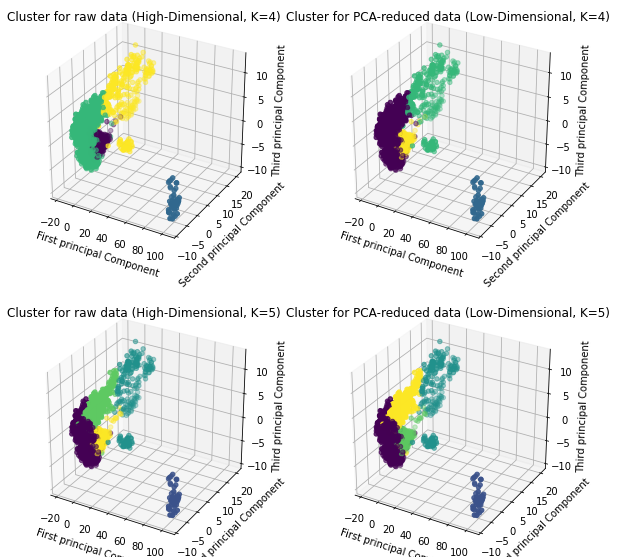

In [19]:
Kmeans_fig = plt.figure(figsize=(10, 10))
ax1 = Kmeans_fig.add_subplot(2,2,1, projection='3d')
kmeans_raw = KMeans(n_clusters=4, random_state=0)
kmeans_raw.fit(raw_data)
y_pred_raw = kmeans_raw.predict(raw_data)
ax1.scatter3D(pca_reduced_data[:,0], pca_reduced_data[:,1],pca_reduced_data[:,2], c=y_pred_raw, cmap=plt.get_cmap('viridis',4))
ax1.set_title('Cluster for raw data (High-Dimensional, K=4)')
ax1.set_xlabel('First principal Component')
ax1.set_ylabel('Second principal Component')
ax1.set_zlabel('Third principal Component')


ax2 = Kmeans_fig.add_subplot(2,2,2, projection='3d')
kmeans_pca_reduced = KMeans(n_clusters=4, random_state=0)
kmeans_pca_reduced.fit(pca_reduced_data)
y_pred_pca_reduced = kmeans_pca_reduced.predict(pca_reduced_data)
ax2.scatter3D(pca_reduced_data[:,0], pca_reduced_data[:,1], pca_reduced_data[:,2], c=y_pred_pca_reduced, cmap=plt.get_cmap('viridis',4))
ax2.set_title('Cluster for PCA-reduced data (Low-Dimensional, K=4)')
ax2.set_xlabel('First principal Component')
ax2.set_ylabel('Second principal Component')
ax2.set_zlabel('Third principal Component')
plt.subplots_adjust(hspace=0.9)

ax3 = Kmeans_fig.add_subplot(2,2,3, projection='3d')
kmeans_raw = KMeans(n_clusters=5, random_state=0)
kmeans_raw.fit(raw_data)
y_pred_raw = kmeans_raw.predict(raw_data)
ax3.scatter3D(pca_reduced_data[:,0], pca_reduced_data[:,1], pca_reduced_data[:,2], c=y_pred_raw, cmap=plt.get_cmap('viridis',5))
ax3.set_title('Cluster for raw data (High-Dimensional, K=5)')
ax3.set_xlabel('First principal Component')
ax3.set_ylabel('Second principal Component')
ax3.set_zlabel('Third principal Component')


ax4 = Kmeans_fig.add_subplot(2,2,4, projection='3d')
kmeans_pca_reduced = KMeans(n_clusters=5, random_state=0)
kmeans_pca_reduced.fit(pca_reduced_data)
y_pred_pca_reduced = kmeans_pca_reduced.predict(pca_reduced_data)
ax4.scatter3D(pca_reduced_data[:,0], pca_reduced_data[:,1], pca_reduced_data[:,2], c=y_pred_pca_reduced, cmap=plt.get_cmap('viridis',5))
ax4.set_title('Cluster for PCA-reduced data (Low-Dimensional, K=5)')
ax4.set_xlabel('First principal Component')
ax4.set_ylabel('Second principal Component')
ax4.set_zlabel('Third principal Component')
plt.subplots_adjust(hspace=0.2)

plt.show()

# **Task 3: Supervised Learning**

In [20]:
x = merged_data

## We split the data by region (80% of the unique regions in the training set and the rest in the validation set). We then perform KNN regression on this train-validation split strategy. 

In [21]:
# After multiple trials with different shuffled data, below is the one that gave the best mean squared error
# so from now on it is the one we'll be using
unique_regions = ['US-KS', 'US-ND', 'US-FL', 'US-WI', 'US-HI', 'US-CO', 'US-TN',
       'US-RI', 'US-WA', 'US-MA', 'US-WY', 'US-MS', 'US-AR', 'US-UT',
       'US-OR', 'US-AZ', 'US-NH', 'US-NM', 'US-GA', 'US-VA', 'US-SC',
       'US-MN', 'US-ID', 'US-IN', 'US-NE', 'US-KY', 'US-OK', 'US-MD',
       'US-ME', 'US-NJ', 'US-SD', 'US-MT', 'US-AL', 'US-OH', 'US-CT']

In [22]:
def knn_and_decisiontree_model(n_neighbours, unique_regions, model_data):
  mse_test, mae_test, mse_tree_test, mae_tree_test = [], [], [] ,[]
  train_set_size = int(len(unique_regions)*0.8)
  validation_set_size = len(unique_regions) - train_set_size

  for i in range(5):
    # KNN
    test_regions = unique_regions[i*validation_set_size:(i+1)*validation_set_size]
    train_regions = [region for region in unique_regions if region not in test_regions]

    x_train = model_data.loc[model_data['open_covid_region_code'].isin(train_regions)]
    y_train = x_train['hospitalized_new']
    x_train.drop(['open_covid_region_code', 'date', 'hospitalized_new'], axis=1, inplace=True)

    x_test = model_data.loc[model_data['open_covid_region_code'].isin(test_regions)]
    y_test = x_test['hospitalized_new']
    x_test.drop(['open_covid_region_code', 'date', 'hospitalized_new'], axis=1, inplace=True)

    neigh = neighbors.KNeighborsRegressor(n_neighbors=n_neighbours, weights='distance', metric='manhattan')

    y_prob_test = neigh.fit(x_train, y_train).predict(x_test)
    mse_test.append(mean_squared_error(y_test, y_prob_test))
    mae_test.append(mean_absolute_error(y_test, y_prob_test))

    # Decision Tree
    tree_regressor = DecisionTreeRegressor(random_state=0)
    y_tree_prob_test = tree_regressor.fit(x_train, y_train).predict(x_test)

    mse_tree_test.append(mean_squared_error(y_test, y_tree_prob_test))
    mae_tree_test.append(mean_absolute_error(y_test, y_tree_prob_test))

  return (mse_test, mae_test, mse_tree_test, mae_tree_test)


In [23]:
mse_errors_knn = []
mae_errors_knn = []

mse_errors_tree = []
mae_errors_tree = []

for n in range(2, 100):
  mse_test, mae_test,_,_ = knn_and_decisiontree_model(n_neighbours=n, unique_regions=unique_regions, model_data=x )
  mse_errors_knn.append(np.mean(mse_test))
  mae_errors_knn.append(np.mean(mae_test))


We plot the KNN model's mean squared error vs the number of neighbours $K$ in the model to determine what would be the best choice of $K$, by looking for the best tradeoff between precision and computational weight.

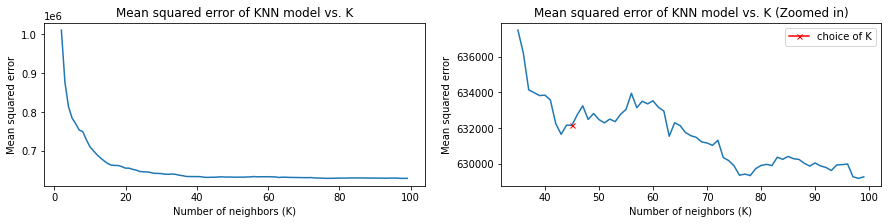

In [24]:
fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(2,100), mse_errors_knn)
ax1.set_xlabel('Number of neighbors (K)')
ax1.set_ylabel('Mean squared error')
ax1.set_title('Mean squared error of KNN model vs. K')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(range(35,100), mse_errors_knn[33:])
ax2.plot(45, mse_errors_knn[43], color='red', marker='x', mew=1, ms=5, label='choice of K')
ax2.set_xlabel('Number of neighbors (K)')
ax2.set_ylabel('Mean squared error')
ax2.set_title('Mean squared error of KNN model vs. K (Zoomed in)')

plt.legend()
plt.show()

In [25]:
mse_test, mae_test, mse_tree_test, mae_tree_test = knn_and_decisiontree_model(n_neighbours=48, unique_regions=unique_regions, model_data=x)
print(f'KNN mean squared error: {np.mean(mse_test)}')
print(f'KNN mean absolute error: {np.mean(mae_test)}')
print(f'Decision tree mean squared error: {np.mean(mse_tree_test)}')
print(f'KNN mean absolute error: {np.mean(mae_tree_test)}')


KNN mean squared error: 632488.9626156191
KNN mean absolute error: 375.37220666259844
Decision tree mean squared error: 1434138.5339595631
KNN mean absolute error: 404.84418700517455


To reduce the error of the model, we tried to reduce the noise by repeating the regression task while keeping only the covid-relevant symptoms in our dataset, and as per our previous analysis, we will use K = 48 neighbors.

In [26]:
covid_symptoms = ['open_covid_region_code', 'date', 'hospitalized_new',
                  'symptom:Chest pain', 'symptom:Chills', 'symptom:Common cold', 'symptom:Confusion',
                  'symptom:Croup','symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue',
                  'symptom:Fever', 'symptom:Headache', 'symptom:Hyperthermia',
                  'symptom:Low-grade fever', 'symptom:Migraine', 'symptom:Muscle weakness', 'symptom:Myalgia',
                  'symptom:Nasal congestion', 'symptom:Nausea', 'symptom:Pneumonia', 'symptom:Rhinorrhea',
                  'symptom:Shivering', 'symptom:Shortness of breath', 'symptom:Sore throat', 'symptom:Throat irritation',
                  'symptom:Syncope', 'symptom:Upper respiratory tract infection', 'symptom:Vomiting', 'symptom:Weakness'] 
covid_relevant_data = x.loc[:, covid_symptoms]

In [29]:
mse_test, mae_test, mse_tree_test, mae_tree_test = knn_and_decisiontree_model(n_neighbours=48, unique_regions=unique_regions, model_data=covid_relevant_data)
print("Error for regression with covid relevant data\n")
print(f'KNN mean squared error: {np.mean(mse_test)}')
print(f'KNN mean absolute error: {np.mean(mae_test)}')
print(f'Decision tree mean squared error: {np.mean(mse_tree_test)}')
print(f'KNN mean absolute error: {np.mean(mae_tree_test)}')

Error for regression with covid relevant data

KNN mean squared error: 622634.8133455727
KNN mean absolute error: 342.98972302959794
Decision tree mean squared error: 1098101.8782582413
KNN mean absolute error: 382.71705082875627


We tried to improve the performance of our KNN model and remove noise in the data by getting rid of the predictions that were way off. We set a threshold equal to the mean absolute error and remove all rows of the dataset whose predictions do not pass this threshold condition.

In [31]:
indices_to_remove = []
train_set_size = int(len(unique_regions)*0.8)
validation_set_size = len(unique_regions) - train_set_size

for i in range(5):
    test_regions = unique_regions[i*validation_set_size:(i+1)*validation_set_size]
    train_regions = [region for region in unique_regions if region not in test_regions]
    x_train = covid_relevant_data.loc[covid_relevant_data['open_covid_region_code'].isin(train_regions)]
    y_train = x_train['hospitalized_new']
    x_train.drop(['open_covid_region_code', 'date', 'hospitalized_new'], axis=1, inplace=True)

    x_test = covid_relevant_data.loc[covid_relevant_data['open_covid_region_code'].isin(test_regions)]
    y_test = x_test['hospitalized_new']
    x_test.drop(['open_covid_region_code', 'date', 'hospitalized_new'], axis=1, inplace=True)

    neigh = neighbors.KNeighborsRegressor(n_neighbors=48, weights='distance', metric='manhattan')
    y_prob_test = neigh.fit(x_train, y_train).predict(x_test)

    for i in range(0, len(y_prob_test)):
      index = y_test.index[i]
      prob = y_prob_test[i]
      truth = y_test.to_numpy()[i]
      
      if abs(prob - truth) > mean_absolute_error(y_test, y_prob_test):
        indices_to_remove.append(index)

# KNN on outlier_filtered_data
outlier_filtered_data = x.drop(index=indices_to_remove)
mse_test, mae_test, mse_tree_test, mae_tree_test = knn_and_decisiontree_model(n_neighbours=48, unique_regions=unique_regions, model_data=outlier_filtered_data)

print("Error for regression with outlier-filtered data\n")
print(f'KNN mean squared error: {np.mean(mse_test)}')
print(f'KNN mean absolute error: {np.mean(mae_test)}')
print(f'Decision tree mean squared error: {np.mean(mse_tree_test)}')
print(f'KNN mean absolute error: {np.mean(mae_tree_test)}')

Error for regression with outlier-filtered data

KNN mean squared error: 44388.150961033265
KNN mean absolute error: 167.63384724998454
Decision tree mean squared error: 66376.66286029274
KNN mean absolute error: 176.78154261538583


## Next we perform KNN regression again, this time using a date-based train-validation split. We keep all data before 2020-08-10 in the training set and put the rest in the test set

In [32]:
def knn_and_decisiontree_model_time(n_neighbours, model_data):
  mse_test, mae_test, mse_tree_test, mae_tree_test = [], [], [] ,[]
  x_time_test = model_data.loc[model_data['date'] >= '2020-08-10']
  y_time_test = x_time_test['hospitalized_new']
  x_time_test.drop(['open_covid_region_code', 'date', 'hospitalized_new' ], axis=1, inplace=True)

  x_time_train = model_data.loc[model_data['date'] < '2020-08-10']
  y_time_train = x_time_train['hospitalized_new']
  x_time_train.drop(['open_covid_region_code', 'date', 'hospitalized_new'], axis=1, inplace=True)

  #KNN
  neighbor_reg = neighbors.KNeighborsRegressor(n_neighbors=n_neighbours)
  y_time_testprob = neighbor_reg.fit(x_time_train, y_time_train).predict(x_time_test)
  mse_test.append(mean_squared_error(y_time_test, y_time_testprob))
  mae_test.append(mean_absolute_error(y_time_test, y_time_testprob))

  # Decision tree
  tree_regressor = DecisionTreeRegressor(random_state=0)
  y_time_tree_test_prob = tree_regressor.fit(x_time_train, y_time_train).predict(x_time_test)

  mse_tree_test.append(mean_squared_error(y_time_test, y_time_tree_test_prob))
  mae_tree_test.append(mean_absolute_error(y_time_test, y_time_tree_test_prob))
  return (mse_test, mae_test, mse_tree_test, mae_tree_test)

In [33]:
mse_timeerrors_knn = []
mae_timeerrors_knn = []

for k in range (2, 100):
  mse_time_test, mae_time_test,_,_ = knn_and_decisiontree_model_time(n_neighbours=k,  model_data=x)
  mse_timeerrors_knn.append(mse_time_test)
  mae_timeerrors_knn.append(mae_time_test)


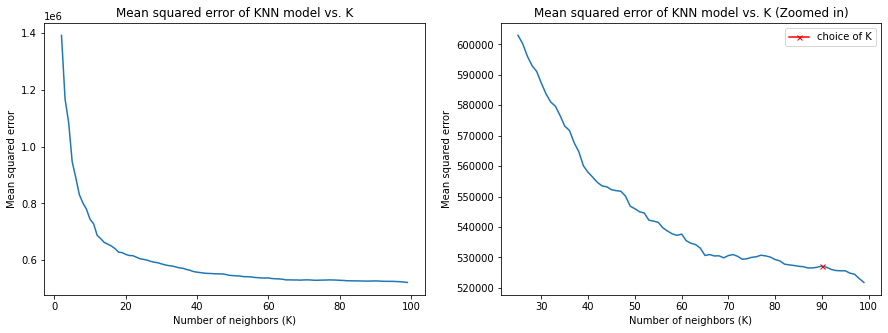

In [34]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(2,100), mse_timeerrors_knn)
ax1.set_xlabel('Number of neighbors (K)')
ax1.set_ylabel('Mean squared error')
ax1.set_title('Mean squared error of KNN model vs. K')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(range(25,100), mse_timeerrors_knn[23:])
ax2.plot(90, mse_timeerrors_knn[88], color='red', marker='x', mew=1, ms=5, label='choice of K')
ax2.set_xlabel('Number of neighbors (K)')
ax2.set_ylabel('Mean squared error')
ax2.set_title('Mean squared error of KNN model vs. K (Zoomed in)')

plt.legend()
plt.show()

In [37]:
mse_test, mae_test, mse_tree_test, mae_tree_test = knn_and_decisiontree_model_time(n_neighbours=62, model_data=x)

print("Error for regression with time-based split\n")
print(f'KNN mean squared error: {np.mean(mse_test)}')
print(f'KNN mean absolute error: {np.mean(mae_test)}')
print(f'Decision tree mean squared error: {np.mean(mse_tree_test)}')
print(f'KNN mean absolute error: {np.mean(mae_tree_test)}')

Error for regression with time-based split

KNN mean squared error: 534634.9130694005
KNN mean absolute error: 406.9092495062541
Decision tree mean squared error: 2125429.432653061
KNN mean absolute error: 701.2163265306123
